# Easy to Fill Model - Random Forest

## Using random forest method to predict probability of a mission being easy-to-fill

## Background:

#### In this model, we aim to predict the probability of a mission being easy-to-fill, where easy-to-fill is defined as a mission that has been voluntarily picked up by a pilot, without a coordinator having sent a plea SMS text message.

#### We used the dataset "ETF_main_data.csv" generated by the query labeled "ETF_SQL_Query.sql" which contains 20,772 missions from 10/1/2016 to 9/30/2019. 

## Library Imports

In [121]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot  as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

## Data Examination

In [122]:
# read in data and examine
etf_data = pd.read_csv("ETF_main_data.csv")
etf_data.head()

,mission_leg_id,easy_to_fill,cancelled,type,no_pilot,passenger_id,age,repeated_passenger,illness,companion_count,...,from_airport_freq,from_runway_length,f_city,to_airport_id,to_airport_freq,to_runway_length,t_city,supply,demand,ratio
0,120168,0,1,No Pilot,1,19215,41.0,1,Caregiver or Companion,0,...,569,11489,Phoenix,4854,1398,8001,Van Nuys,355,82,4.3293
1,117658,1,0,NaN,0,1143,31.0,1,NaN,1,...,1834,6886,Burbank,4845,1624,6559,Visalia,115,36,3.1944
2,117658,1,0,NaN,0,1143,31.0,1,NaN,1,...,1834,6886,Burbank,4845,1624,6559,Visalia,115,36,3.1944
3,117658,1,0,NaN,0,1143,31.0,1,NaN,1,...,1834,6886,Burbank,4845,1624,6559,Visalia,115,36,3.1944
4,118979,1,0,NaN,0,18605,56.0,1,Cancer,0,...,1644,6501,Las Vegas,4494,13034,4973,Santa Monica,208,58,3.5862


In [123]:
etf_data.columns.values

array(['mission_leg_id', 'easy_to_fill', 'cancelled', 'type', 'no_pilot',
       'passenger_id', 'age', 'repeated_passenger', 'illness',
       'companion_count', 'total_weight', 'leg_count', 'appt_time_type',
       'year', 'weekday_of_mission', 'month', 'lead_time', 'season',
       'leg_distance', 'total_distance', 'from_airport_id',
       'from_airport_freq', 'from_runway_length', 'f_city',
       'to_airport_id', 'to_airport_freq', 'to_runway_length', 't_city',
       'supply', 'demand', 'ratio'], dtype=object)

## Data Preparation

### Dealing with NaNs

In [124]:
# check values for appt time
etf_data['appt_time_type'].unique()

array([nan, 'other', 'early', 'late'], dtype=object)

In [125]:
# turn appt time NaNs into string to be used as a category
appt_time = etf_data['appt_time_type'].replace(np.nan, 'NA', regex = True)
etf_data = etf_data.drop('appt_time_type', 1)

# turn age NaNs into string
age = etf_data['age'].replace(np.nan, 'NA', regex = True)
etf_data = etf_data.drop('age', 1)

# add converted appt time & age variables back into model
etf_data = pd.concat([etf_data, appt_time, age], axis = 1)

In [126]:
# create and add age_null dummy variable to data set to explain missing values
age_dummy = pd.get_dummies(etf_data['age'], prefix='age', drop_first=True)   #reduce one degree of freedom
etf_data = pd.concat([etf_data, age_dummy['age_NA']], axis = 1)

# replace age nulls with 0
age = etf_data['age'].replace('NA', 0)
etf_data = etf_data.drop('age', 1)
etf_data = pd.concat([etf_data, age], axis = 1)

In [127]:
# drop lead time NaNs (there are only 4)
etf_data = etf_data[pd.notnull(etf_data.lead_time)]

### Data Exploration

In [128]:
# check to see variable names
etf_data.columns.values

array(['mission_leg_id', 'easy_to_fill', 'cancelled', 'type', 'no_pilot',
       'passenger_id', 'repeated_passenger', 'illness', 'companion_count',
       'total_weight', 'leg_count', 'year', 'weekday_of_mission', 'month',
       'lead_time', 'season', 'leg_distance', 'total_distance',
       'from_airport_id', 'from_airport_freq', 'from_runway_length',
       'f_city', 'to_airport_id', 'to_airport_freq', 'to_runway_length',
       't_city', 'supply', 'demand', 'ratio', 'appt_time_type', 'age_NA',
       'age'], dtype=object)

In [129]:
etf_data.describe

<bound method NDFrame.describe of        mission_leg_id  easy_to_fill  cancelled      type  no_pilot  \
0              120168             0          1  No Pilot         1   
1              117658             1          0       NaN         0   
2              117658             1          0       NaN         0   
3              117658             1          0       NaN         0   
4              118979             1          0       NaN         0   
...               ...           ...        ...       ...       ...   
20767          151700             0          1  No Pilot         1   
20768          151031             0          0       NaN         0   
20769          151034             0          1   Weather         0   
20770          151038             0          1  No Pilot         1   
20771          151977             0          0       NaN         0   

       passenger_id  repeated_passenger                 illness  \
0             19215                   1  Caregiver or Comp

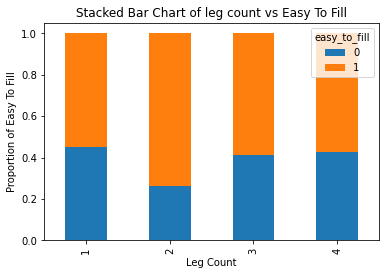

In [130]:
table=pd.crosstab(etf_data.leg_count,etf_data.easy_to_fill)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of leg count vs Easy To Fill')
plt.xlabel('Leg Count')
plt.ylabel('Proportion of Easy To Fill')
plt.savefig('Leg_count_ETF')

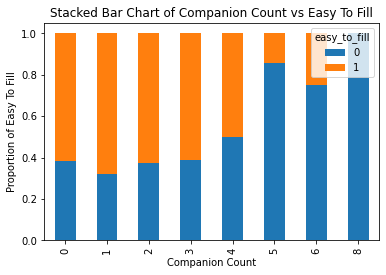

In [131]:
table=pd.crosstab(etf_data.companion_count,etf_data.easy_to_fill)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Companion Count vs Easy To Fill')
plt.xlabel('Companion Count')
plt.ylabel('Proportion of Easy To Fill')
plt.savefig('Companion_count_ETF')

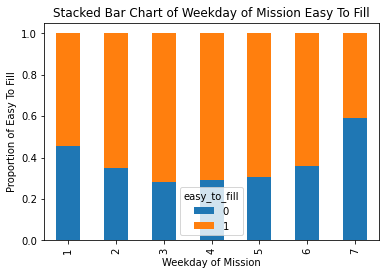

In [132]:
table=pd.crosstab(etf_data.weekday_of_mission,etf_data.easy_to_fill)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Weekday of Mission Easy To Fill')
plt.xlabel('Weekday of Mission')
plt.ylabel('Proportion of Easy To Fill')
plt.savefig('Weekday_ETF')


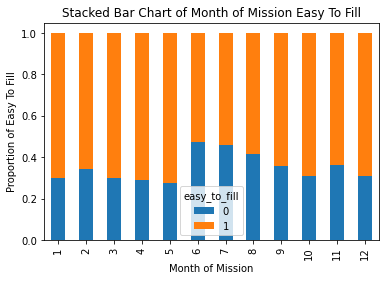

In [133]:
table=pd.crosstab(etf_data.month,etf_data.easy_to_fill)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Month of Mission Easy To Fill')
plt.xlabel('Month of Mission')
plt.ylabel('Proportion of Easy To Fill')
plt.savefig('Month_ETF')

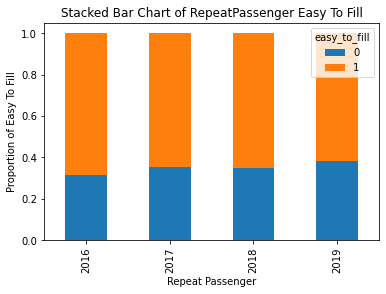

In [134]:
table=pd.crosstab(etf_data.year,etf_data.easy_to_fill)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of RepeatPassenger Easy To Fill')
plt.xlabel('Repeat Passenger')
plt.ylabel('Proportion of Easy To Fill')
plt.savefig('RepeatPassenger_ETF')

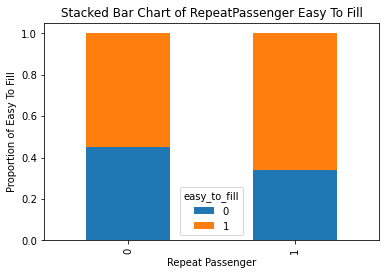

In [135]:
table=pd.crosstab(etf_data.repeated_passenger,etf_data.easy_to_fill)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of RepeatPassenger Easy To Fill')
plt.xlabel('Repeat Passenger')
plt.ylabel('Proportion of Easy To Fill')
plt.savefig('RepeatPassenger_ETF')

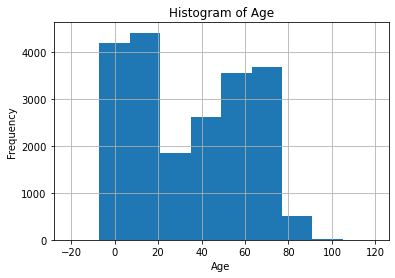

In [136]:
etf_data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

### Running a logistic regression to identify significant variables for the model

In [137]:
df3 = etf_data.copy()

In [138]:
df3.columns.values

array(['mission_leg_id', 'easy_to_fill', 'cancelled', 'type', 'no_pilot',
       'passenger_id', 'repeated_passenger', 'illness', 'companion_count',
       'total_weight', 'leg_count', 'year', 'weekday_of_mission', 'month',
       'lead_time', 'season', 'leg_distance', 'total_distance',
       'from_airport_id', 'from_airport_freq', 'from_runway_length',
       'f_city', 'to_airport_id', 'to_airport_freq', 'to_runway_length',
       't_city', 'supply', 'demand', 'ratio', 'appt_time_type', 'age_NA',
       'age'], dtype=object)

In [139]:
# removing the ids (mission_leg_id, passenger_id, from_airport_id, to_airport_id), year, to_city and from_city 
# from the data in order to avoid over-fitting

df3 = df3[['easy_to_fill', 'cancelled', 'type', 'no_pilot',
       'repeated_passenger', 'illness', 'companion_count',
       'total_weight', 'leg_count', 'weekday_of_mission', 'month',
       'lead_time', 'season', 'leg_distance', 'total_distance',
       'from_airport_freq', 'from_runway_length',
        'to_airport_freq', 'to_runway_length',
        'supply', 'demand', 'ratio', 'appt_time_type', 'age_NA',
       'age']]

In [140]:
#create dummies for categorical variables
dummies_1 = ['easy_to_fill', 'cancelled', 'type',
             'repeated_passenger', 'illness', 'appt_time_type', 
             'leg_count', 'weekday_of_mission', 'month', 'season', 'age_NA']


for dummy_var in dummies_1:
    cat_list = 'var' + '_' + dummy_var
    cat_list = pd.get_dummies(df3[dummy_var], prefix=dummy_var,drop_first=True)   #reduce one degree of freedom
    df3 = pd.concat([df3, cat_list], axis = 1)
    df3 = df3.drop(dummy_var, 1)

In [141]:
df3.columns.values

array(['no_pilot', 'companion_count', 'total_weight', 'lead_time',
       'leg_distance', 'total_distance', 'from_airport_freq',
       'from_runway_length', 'to_airport_freq', 'to_runway_length',
       'supply', 'demand', 'ratio', 'age', 'easy_to_fill_1',
       'cancelled_1', 'type_No Pilot', 'type_No Pilot Other Leg',
       'type_Other Agency', 'type_Passenger',
       'type_Passenger Appt Change', 'type_Passenger Concern',
       'type_Passenger Health', 'type_Pilot', 'type_Requester',
       'type_Self', 'type_Short Notice', 'type_Weather',
       'type_Weather Other Leg', 'repeated_passenger_1', 'illness_Burns',
       'illness_Cancer', 'illness_Cardiac',
       'illness_Caregiver or Companion', 'illness_Deafness',
       'illness_Dermatalogical', 'illness_Disaster',
       'illness_Domestic violence', 'illness_Gastro-intestinal',
       'illness_HIV', 'illness_Injury', 'illness_Kidney Disease',
       'illness_Liver Disease', 'illness_Military/Veteran',
       'illness_Natal',

In [142]:
# split into X and y variables
X = df3.drop('easy_to_fill_1', 1)
y = df3['easy_to_fill_1']

In [143]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35


C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                                         Results: Logit
Model:                          Logit                        Pseudo R-squared:             inf   
Dependent Variable:             easy_to_fill_1               AIC:                          inf   
Date:                           2020-04-07 18:10             BIC:                          inf   
No. Observations:               20768                        Log-Likelihood:               -inf  
Df Model:                       74                           LL-Null:                      0.0000
Df Residuals:                   20693                        LLR p-value:                  1.0000
Converged:                      0.0000                       Scale:                        1.0000
No. Iterations:                 35.0000                                                          
-------------------------------------------------------------------------------------------------
                                Coef.     Std.Err.      z     

C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [144]:
# Based on this we eliminate the variables which have high p-values. Those variables are cancelled, type, no_pilot, ratio

In [145]:
X = X.drop(['no_pilot','cancelled_1','type_No Pilot', 'type_No Pilot Other Leg',
       'type_Other Agency', 'type_Passenger',
       'type_Passenger Appt Change', 'type_Passenger Concern',
       'type_Passenger Health', 'type_Pilot', 'type_Requester',
       'type_Self', 'type_Short Notice', 'type_Weather',
       'type_Weather Other Leg','ratio'] , axis = 1)

In [146]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 6


C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                                Results: Logit
Model:                    Logit                  Pseudo R-squared:       inf   
Dependent Variable:       easy_to_fill_1         AIC:                    inf   
Date:                     2020-04-07 18:10       BIC:                    inf   
No. Observations:         20768                  Log-Likelihood:         -inf  
Df Model:                 59                     LL-Null:                0.0000
Df Residuals:             20708                  LLR p-value:            1.0000
Converged:                1.0000                 Scale:                  1.0000
No. Iterations:           6.0000                                               
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
companion_count                 0.2921   0.0444   6.5812 0.0000  0.2051  

C:\Users\meha\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


## Variable Selection

In [147]:
# select variables to use in model
etf_data = etf_data[['easy_to_fill', 'no_pilot', 'repeated_passenger', 'age', 'illness', 'companion_count', 'total_weight', 'leg_count', 'appt_time_type',
                     'weekday_of_mission', 'month', 'lead_time', 'season', 'leg_distance', 'total_distance', 'from_airport_freq', 
                     'from_runway_length', 'to_airport_freq', 'to_runway_length', 'supply', 'demand','age_NA']] 

### Create Dummy Variables

In [148]:
#create dummies for categorical variables
dummies = ['easy_to_fill', 'repeated_passenger', 'illness', 'appt_time_type', 'leg_count', 'weekday_of_mission', 'month', 'season', 'age_NA']


for dummy_var in dummies:
    cat_list = 'var' + '_' + dummy_var
    cat_list = pd.get_dummies(etf_data[dummy_var], prefix=dummy_var,drop_first=True)   #reduce one degree of freedom
    etf_data = pd.concat([etf_data, cat_list], axis = 1)
    etf_data = etf_data.drop(dummy_var, 1)



In [149]:
# one last check for any more NaNs
etf_data.isna().sum()

no_pilot           0
age                0
companion_count    0
total_weight       0
lead_time          0
                  ..
month_10           0
month_11           0
month_12           0
season_1           0
age_NA_1           0
Length: 62, dtype: int64

In [150]:
etf_data.describe()

,no_pilot,age,companion_count,total_weight,lead_time,leg_distance,total_distance,from_airport_freq,from_runway_length,to_airport_freq,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,season_1,age_NA_1
count,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,...,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000,20768.000000
mean,0.069915,34.467113,0.575982,257.709505,22.690437,178.119944,275.499663,3021.538087,6848.037317,3576.131500,...,0.085998,0.103091,0.111807,0.099384,0.083927,0.079497,0.072612,0.067411,0.436296,0.064811
std,0.255010,25.977450,0.681536,111.049487,23.887091,88.094958,216.230813,3802.336688,2705.193681,4035.881718,...,0.280367,0.304085,0.315136,0.299184,0.277285,0.270520,0.259504,0.250739,0.495937,0.246198
min,0.000000,-21.000000,0.000000,0.000000,-336.000000,0.000000,0.000000,1.000000,2140.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.000000,0.000000,170.000000,9.000000,113.000000,114.000000,394.000000,4973.000000,521.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,34.000000,0.000000,232.000000,16.000000,183.000000,202.000000,1280.000000,6052.000000,1771.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,59.000000,1.000000,333.000000,29.000000,228.000000,357.000000,3607.000000,9217.000000,4772.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,119.000000,8.000000,1157.000000,543.000000,1979.000000,1979.000000,13034.000000,16000.000000,13034.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [151]:
etf_data.columns.values

array(['no_pilot', 'age', 'companion_count', 'total_weight', 'lead_time',
       'leg_distance', 'total_distance', 'from_airport_freq',
       'from_runway_length', 'to_airport_freq', 'to_runway_length',
       'supply', 'demand', 'easy_to_fill_1', 'repeated_passenger_1',
       'illness_Burns', 'illness_Cancer', 'illness_Cardiac',
       'illness_Caregiver or Companion', 'illness_Deafness',
       'illness_Dermatalogical', 'illness_Disaster',
       'illness_Domestic violence', 'illness_Gastro-intestinal',
       'illness_HIV', 'illness_Injury', 'illness_Kidney Disease',
       'illness_Liver Disease', 'illness_Military/Veteran',
       'illness_Natal', 'illness_Neurological', 'illness_No illness',
       'illness_Orthopedic', 'illness_Other', 'illness_Pulmonary',
       'illness_Transplant', 'illness_Trauma Patient',
       'appt_time_type_early', 'appt_time_type_late',
       'appt_time_type_other', 'leg_count_2', 'leg_count_3',
       'leg_count_4', 'weekday_of_mission_2', 'weekday

### Split into Test and Train Data

In [152]:
# split into X and y variables
X = etf_data.drop('easy_to_fill_1', 1)
y = etf_data['easy_to_fill_1']

In [153]:
# split into testing and training data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [154]:
# remove observations from training data where no_pilot = 1

# reset index for X and y train
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# create list of rows to drop
drop_train_rows = []
for index, row in X_train.iterrows():
    if row['no_pilot'] == 1:
        drop_train_rows.append(index)
    else:
        pass

# drop rows
X_train = X_train.drop(X_train.index[drop_train_rows], 0)
y_train = y_train.drop(y_train.index[drop_train_rows], 0)

In [155]:
# drop no pilot
X_train = X_train.drop('no_pilot', 1)
X_test = X_test.drop('no_pilot', 1)

In [156]:
# check shape of train and test
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (14516, 60)
Training Labels Shape: (14516,)
Testing Features Shape: (5192, 60)
Testing Labels Shape: (5192,)


In [157]:
# write train & test datasets to csv
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv(r'etf_train_data.csv', index = False)
test_data.to_csv(r'etf_test_data.csv', index = False)

## Random Forest Model

In [158]:
# initiate random forest model
rfc = RandomForestClassifier()

# fit random forest classifier model to training data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [159]:
# predict easy-to-fill using testing data
etf_predictions = rfc.predict(X_test)

## Model Evaluation

In [160]:
# accuracy score
print('Accuracy of random forest classifier on test set: {:.2f}'.format(accuracy_score(etf_predictions, y_test)))

Accuracy of random forest classifier on test set: 0.79


In [161]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, etf_predictions)
print(conf_matrix)

[[ 949  879]
 [ 223 3141]]


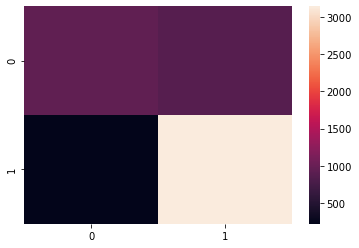

In [162]:
# visualize confusion matrix as a heatmap
sns.heatmap(conf_matrix)
plt.show()

In [163]:
# calculate roc auc
roc_value = roc_auc_score(y_test, etf_predictions)
print(roc_value)

0.7264282387592138


In [164]:
f1_score(y_test, etf_predictions)

0.8507583965330444

In [165]:
# classification report
print("=== Classification Report ===")
print(classification_report(y_test, etf_predictions))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.52      0.63      1828
           1       0.78      0.93      0.85      3364

    accuracy                           0.79      5192
   macro avg       0.80      0.73      0.74      5192
weighted avg       0.79      0.79      0.77      5192



In [166]:
# other evaluation methods
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== All AUC Scores ===
[0.78267529 0.83493656 0.82129202 0.78386381 0.80984409 0.81672585
 0.71255465 0.62814696 0.78442505 0.74521951]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7719683794419796
